## Download data via API

In [1]:
import requests

# Example URL for a traffic dataset (change date/month as needed)
url = 'https://datos.madrid.es/egob/catalogo/208627-148-transporte-ptomedida-historico.zip'

response = requests.get(url)
if response.status_code == 200:
    with open('septiembre.zip', 'wb') as f:
        f.write(response.content)
    print("Download complete!")
else:
    print("Download failed. Status code:", response.status_code)


Download complete!


In [4]:
import os
# Unzip the downloaded file
# importing the zipfile module
from zipfile import ZipFile

# loading the septiembre.zip and creating a zip object
with ZipFile("septiembre.zip", 'r') as zObject:

    # Extracting all the members of the zip 
    # into a specific location.
    # check if the file already exists to avoid overwriting
    if os.path.exists("/Users/annakober/Desktop/Uni/Master/Erasmus/Programming_cities/ciudades_sostenibles/data/"):
        print("Data folder already exists. Skipping extraction.")
    else:
        zObject.extractall(path="/Users/annakober/Desktop/Uni/Master/Erasmus/Programming_cities/ciudades_sostenibles/data/")
    
# delete the zip file after extraction
import os
os.remove("septiembre.zip")


Data folder already exists. Skipping extraction.


## Get overview

In [50]:
# load data into pandas dataframe
import pandas as pd
import numpy as np

data = pd.read_csv('/Users/annakober/Desktop/Uni/Master/Erasmus/Programming_cities/ciudades_sostenibles/data/09-2025.csv', sep=';')

# explore data
data.info()
data.describe()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13082675 entries, 0 to 13082674
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   fecha                object 
 2   tipo_elem            object 
 3   intensidad           int64  
 4   ocupacion            int64  
 5   carga                int64  
 6   vmed                 float64
 7   error                object 
 8   periodo_integracion  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 898.3+ MB


,id,fecha,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion
0,1006,2025-09-01 00:00:00,C30,660,2,0,60.0,N,5
1,1006,2025-09-01 00:15:00,C30,324,1,0,60.0,N,5
2,1006,2025-09-01 00:30:00,C30,228,0,0,63.0,N,5
3,1006,2025-09-01 00:45:00,C30,96,0,0,61.0,N,5
4,1006,2025-09-01 01:00:00,C30,264,1,0,61.0,N,5


In [51]:
## transform and clean up dataframe 
# convert column fecha to datetime
data["fecha"] = pd.to_datetime(data["fecha"])
data = data.set_index("fecha")

# check for errors and remove them
print("Number of non optimal or errouneous observations:", len(data[data["error"] != "N"]))
data = data[data["error"] == "N"] # keep only good observations

# create column with total number of cars per 15 minute period
data["coches_total"] = data["intensidad"] / 4



Number of non optimal or errouneous observations: 76336


## Get statistical overview 

In [79]:
# calculate mode
def mode(series):
    mode_result = series.mode()
    return mode_result.iloc[0] if len(mode_result) > 0 else series.median()


# calculate sensor statistics
def sensor_statistics(data, sensor, aggregation_period = None):

    if sensor in ["M30", "C30"]:
        # filter dataframe
        data_m30 = data[(data["tipo_elem"] == "C30") | (data["tipo_elem"] == "M30")]

        # Resampling but only for numeric columsn
        if aggregation_period is not None:
            # get numeric columns
            numeric_cols = ["intensidad", "vmed", "ocupacion", "carga", "coches_total"]
            # keep id column to group by
            data_m30 = data_m30.groupby("id")[numeric_cols].resample(aggregation_period).mean().reset_index(level=0)
        
        # aggregate dataframe 
        data_m30_agg = data_m30.groupby("id").agg({
            "intensidad": ["min", "max", "mean", "median"], 
            "vmed": ["min", "max", "mean", "median"]
        })
        
        # Modus für jeden Sensor berechnen
        intensity_modes = data_m30.groupby("id")["intensidad"].apply(mode)
        speed_modes = data_m30.groupby("id")["vmed"].apply(mode)
        
        print("M30/C30 statistics")

        # print sensor with minimum and maximum intensity
        print(f"Sensor id with minimum intensity {data_m30_agg["intensidad"]["min"].idxmin()}")
        print(f"Sensor id with maximum intensity {data_m30_agg["intensidad"]["max"].idxmax()}")
        
        # find closest sensor 
        for stat in ["mean", "median"]:
            for char in ["intensidad", "vmed"]:
                overall_stat = data_m30_agg[char][stat].mean()
                closest_sensor = abs(data_m30_agg[char][stat] - overall_stat).idxmin()
                print(f"Sensor id closest to {stat} {char}: {closest_sensor} (value: {overall_stat:.1f})")
        
        # closest sensor to mode 
        intensity_overall_mode = intensity_modes.mean()
        speed_overall_mode = speed_modes.mean()
        
        closest_sensor_intensity_mode = abs(intensity_modes - intensity_overall_mode).idxmin()
        closest_sensor_speed_mode = abs(speed_modes - speed_overall_mode).idxmin()
        
        print(f"Sensor id closest to mode intensidad: {closest_sensor_intensity_mode} (value: {intensity_overall_mode:.1f})")
        print(f"Sensor id closest to mode vmed: {closest_sensor_speed_mode} (value: {speed_overall_mode:.1f})")

    elif sensor == "URB":
        data_urbano = data[data["tipo_elem"] == "URB"]

        # Resampling
        if aggregation_period is not None:
            numeric_cols = ["intensidad", "vmed", "ocupacion", "carga", "coches_total"]
            data_urbano = data_urbano.groupby("id")[numeric_cols].resample(aggregation_period).mean().reset_index(level=0)

        # aggregate dataframe
        data_urbano_agg = data_urbano.groupby("id").agg({
            "intensidad": ["min", "max", "mean", "median"], 
            "vmed": ["min", "max", "mean", "median"]
        })
        
        intensity_modes = data_urbano.groupby("id")["intensidad"].apply(mode)

        print("urban sensor statistics")

        # print sensor with minimum and maximum intensity
        print(f"Sensor id with minimum intensity {data_urbano_agg["intensidad"]["min"].idxmin()}")
        print(f"Sensor id with maximum intensity {data_urbano_agg["intensidad"]["max"].idxmax()}")
        
        # find closest sensor
        for stat in ["mean", "median"]:
            overall_stat = data_urbano_agg["intensidad"][stat].mean()
            closest_sensor = abs(data_urbano_agg["intensidad"][stat] - overall_stat).idxmin()
            print(f"Sensor id closest to {stat} intensity: {closest_sensor} (value: {overall_stat:.1f})")
        
        # Modus
        overall_mode = intensity_modes.mean()
        closest_sensor_mode = abs(intensity_modes - overall_mode).idxmin()
        print(f"Sensor id closest to mode intensity: {closest_sensor_mode} (value: {overall_mode:.1f})")

    else:
        print(f"unknown sensor type: {sensor}")
        return None

In [80]:
sensor_statistics(data, "M30", aggregation_period=None)

M30/C30 statistics
Sensor id with minimum intensity 1006
Sensor id with maximum intensity 6842
Sensor id closest to mean intensidad: 3495 (value: 1164.5)
Sensor id closest to mean vmed: 6640 (value: 60.6)
Sensor id closest to median intensidad: 6771 (value: 1297.8)
Sensor id closest to median vmed: 3542 (value: 64.2)
Sensor id closest to mode intensidad: 6747 (value: 475.3)
Sensor id closest to mode vmed: 3532 (value: 64.2)


## Statistics for different sensors

In [ ]:
def get_relevant_sensors(data, sensor_type, aggregation_period = None):
    """Create statitsics for all sensors and save relevant sensor ids in dictionary for further plotting"""
    
    if sensor_type in ["M30", "C30"]:
        print(f"\n Relevant statistic for sensor type M30 with aggregation period: {aggregation_period}")
        data_filtered = data[(data["tipo_elem"] == "C30") | (data["tipo_elem"] == "M30")]
    elif sensor_type == "URB":
        print(f"\n Relevant statistic for sensor type URB with aggregation period: {aggregation_period}")
        data_filtered = data[data["tipo_elem"] == "URB"]
    else:
        return None
    
    # Resampling but only for numeric columsn
    if aggregation_period is not None:
        # get numeric columns
        numeric_cols = ["intensidad", "vmed", "ocupacion", "carga", "coches_total"]
        # keep id column to group by
        data_filtered = data_filtered.groupby("id")[numeric_cols].resample(aggregation_period).mean().reset_index(level=0)

    # Aggregierte Statistiken berechnen
    data_agg = data_filtered.groupby("id").agg({
        "intensidad": ["min", "max", "mean", "median"], 
        "vmed": ["min", "max", "mean", "median"]
    })
    
    # Modus berechnen
    def safe_mode(series):
        mode_result = series.mode()
        return mode_result.iloc[0] if len(mode_result) > 0 else series.median()
    
    intensity_modes = data_filtered.groupby("id")["intensidad"].apply(safe_mode)
    
    # Relevante Sensoren sammeln
    relevant_sensors = {
        'min_intensity': data_agg["intensidad"]["min"].idxmin(),
        'max_intensity': data_agg["intensidad"]["max"].idxmax(),
        'mean_intensity': abs(data_agg["intensidad"]["mean"] - data_agg["intensidad"]["mean"].mean()).idxmin(),
        'median_intensity': abs(data_agg["intensidad"]["median"] - data_agg["intensidad"]["median"].mean()).idxmin(),
        'mode_intensity': abs(intensity_modes - intensity_modes.mean()).idxmin(),
        'mean_speed': abs(data_agg["vmed"]["mean"] - data_agg["vmed"]["mean"].mean()).idxmin()
    }

    ## print statistics
    # print sensor with minimum and maximum intensity
    print(f"Sensor id with minimum intensity {relevant_sensors['min_intensity']}")
    print(f"Sensor id with maximum intensity {relevant_sensors['max_intensity']}")

    # print sensors closest to mean and median value
    for stat in ["mean", "median"]:
        for char in ["intensidad", "vmed"]:
            overall_stat = data_agg[char][stat].mean()
            closest_sensor = abs(data_agg[char][stat] - overall_stat).idxmin()
            print(f"Sensor id closest to {stat} {char}: {closest_sensor} (value: {overall_stat:.1f})")

    # print sensors closest to mode
    # closest sensor to mode 
    if sensor_type in ["M30", "C30"]:
        speed_modes = data_filtered.groupby("id")["vmed"].apply(safe_mode)
        speed_overall_mode = speed_modes.mean()
        closest_sensor_speed_mode = abs(speed_modes - speed_overall_mode).idxmin()
        print(f"Sensor id closest to mode vmed: {closest_sensor_speed_mode} (value: {speed_overall_mode:.1f})")

    print(f"Sensor id closest to mode intensidad: {relevant_sensors['mode_intensity']} (value: {intensity_modes.mean():.1f})")
    
    return relevant_sensors, data_filtered

# Relevante Sensoren für M30/C30 und URB identifizieren
m30_sensors, m30_data = get_relevant_sensors(data, "M30", aggregation_period = None)
urb_sensors, urb_data = get_relevant_sensors(data, "URB", aggregation_period = None)



 Relevant statistic for sensor type M30 with aggregation period: None
Sensor id with minimum intensity 1006
Sensor id with maximum intensity 6842
Sensor id closest to mean intensidad: 3495 (value: 1164.5)
Sensor id closest to mean vmed: 6640 (value: 60.6)
Sensor id closest to median intensidad: 6771 (value: 1297.8)
Sensor id closest to median vmed: 3542 (value: 64.2)
Sensor id closest to mode vmed: 3532 (value: 64.2)
Sensor id closest to mode intensidad: 6747 (value: 475.3)

 Relevant statistic for sensor type URB with aggregation period: None
Sensor id with minimum intensity 3395
Sensor id with maximum intensity 3624
Sensor id closest to mean intensidad: 11107 (value: 288.0)
Sensor id closest to mean vmed: 3395 (value: 0.0)
Sensor id closest to median intensidad: 5331 (value: 300.3)
Sensor id closest to median vmed: 3395 (value: 0.0)
Sensor id closest to mode intensidad: 3623 (value: 211.6)


## Basic plotting

In [123]:
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

def plot_sensor_traffic(data, sensor_id, sensor_type, date=None):
    """
    visualize data for specific sensor
    """
    
    # filter sensor data
    sensor_data = data[data['id'] == sensor_id].copy()
    sensor_data["week"] = sensor_data.index.isocalendar().week

    
    if sensor_data.empty:
        print(f"No data for {sensor_id}")
        return
    
    # if date is None take first available date with data
    if date is None:
        date = sensor_data.index.date[0]
    
    # filter for specific date, week and month of date
    daily_data = sensor_data[sensor_data.index.date == pd.to_datetime(date).date()]
    weekly_data = sensor_data[(sensor_data["week"] == pd.to_datetime(date).isocalendar().week)]
    monthly_data = sensor_data[sensor_data.index.month == pd.to_datetime(date).month]
    
    if daily_data.empty:
        print(f"No data for {sensor_id} on the {date}")
        return
    
    # Resample für 15 Minuten und 1 Stunde
    data_15min = daily_data
    
    data_1hour = daily_data.resample('h').agg({
        'intensidad': 'mean', 
        'vmed': 'mean',
        'coches_total': 'sum'
    })

    data_daily = weekly_data.resample('D').agg({
        'intensidad': 'mean', 
        'vmed': 'mean',
        'coches_total': 'sum'
    })

    data_weekly = monthly_data.resample('W').agg({
        'intensidad': 'mean', 
        'vmed': 'mean',
        'coches_total': 'sum'
    })

    # plot all data
    for i in [data_15min, data_1hour, data_daily, data_weekly]:
        for stat in ['coches_total', 'vmed']:
            if stat == 'coches_total':
                plt.figure(figsize=(16, 8), dpi=150)
                plt.plot(i.index, i[stat], 
                            marker='s', linewidth=2, markersize=4, color='red')
                plt.title('Total number of cars')
                plt.ylabel(f'{stat}')
                plt.grid(True, alpha=0.3)
                plt.tick_params(axis='x', rotation=45)
                plt.show()
            else:
                plt.figure(figsize=(16, 8), dpi=150)
                plt.plot(i.index, i[stat], 
                            marker='s', linewidth=2, markersize=4, color='blue')
                plt.title('Mean velocity')
                plt.ylabel(f'{stat}')
                plt.grid(True, alpha=0.3)
                plt.tick_params(axis='x', rotation=45)
                plt.show()
    

Analyzing sensor id: 6842


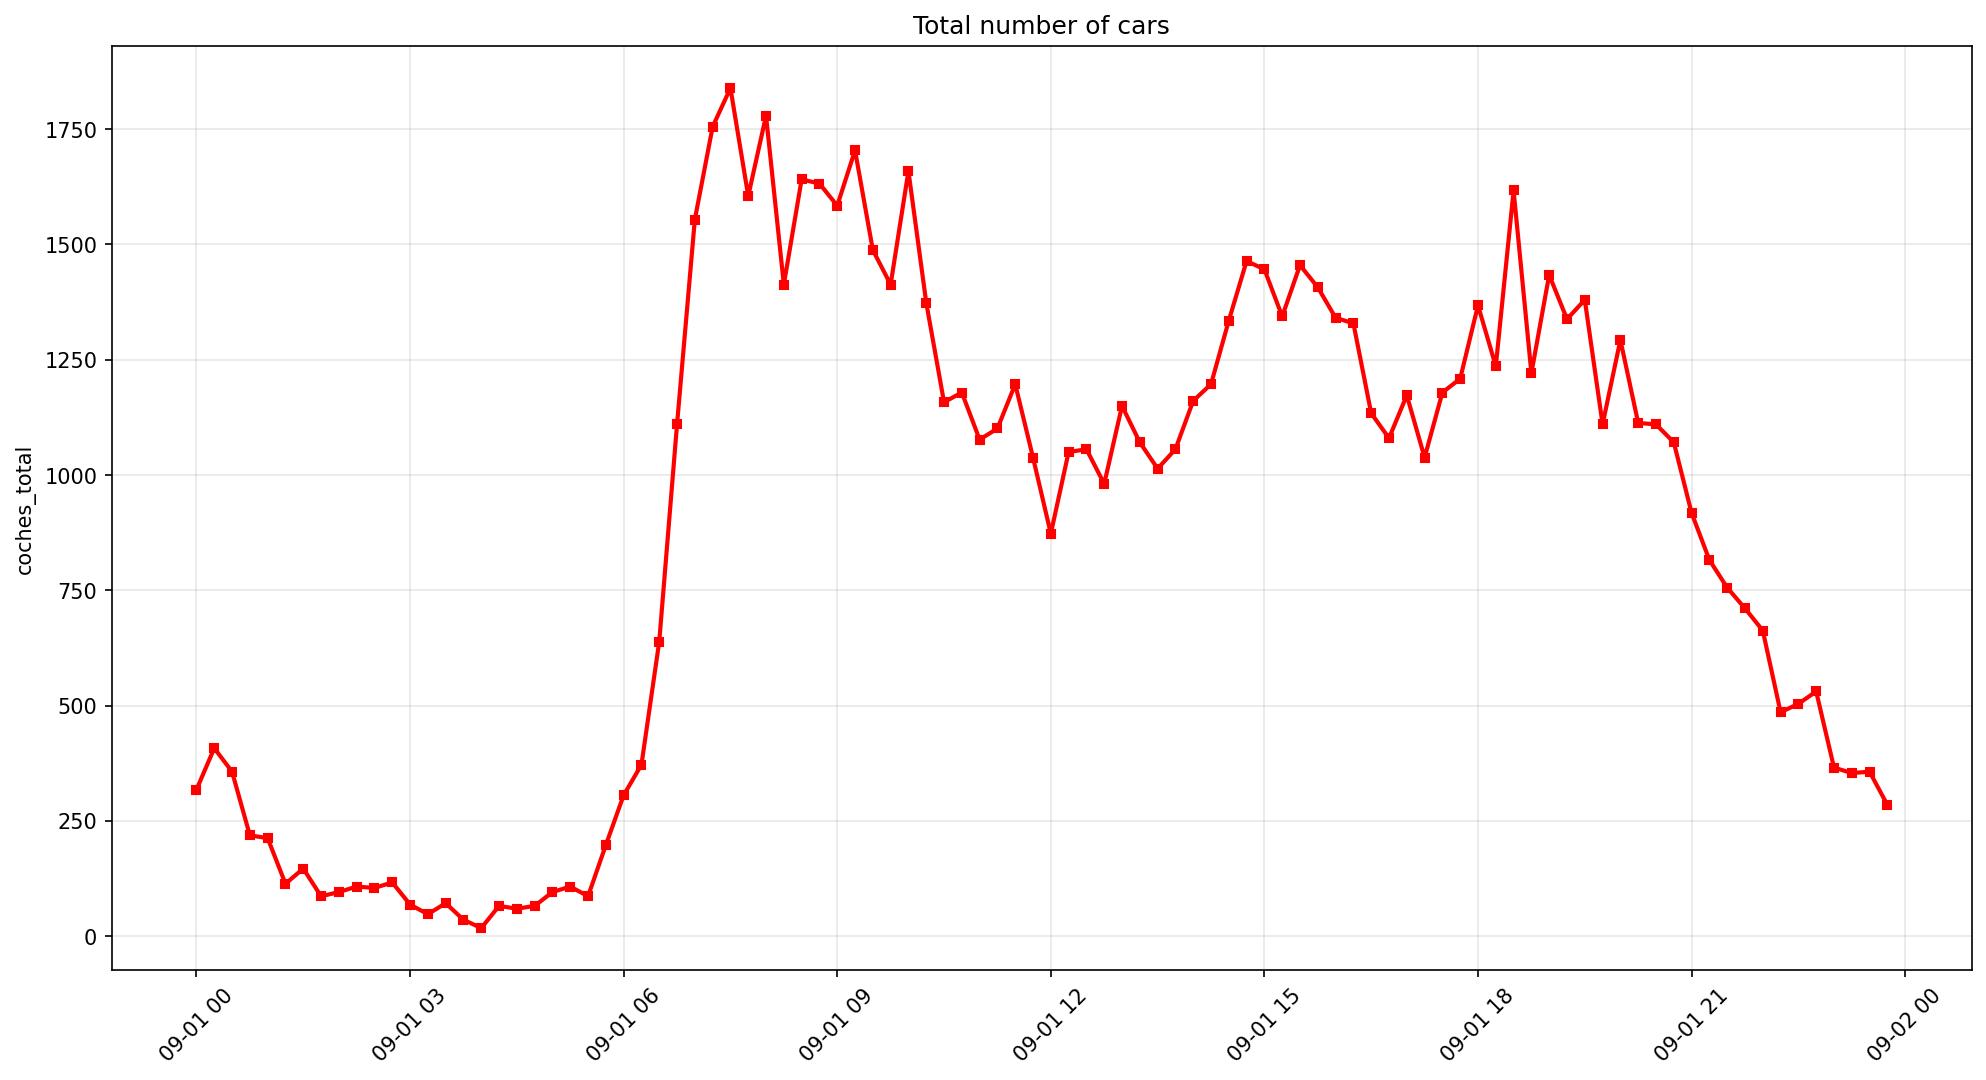

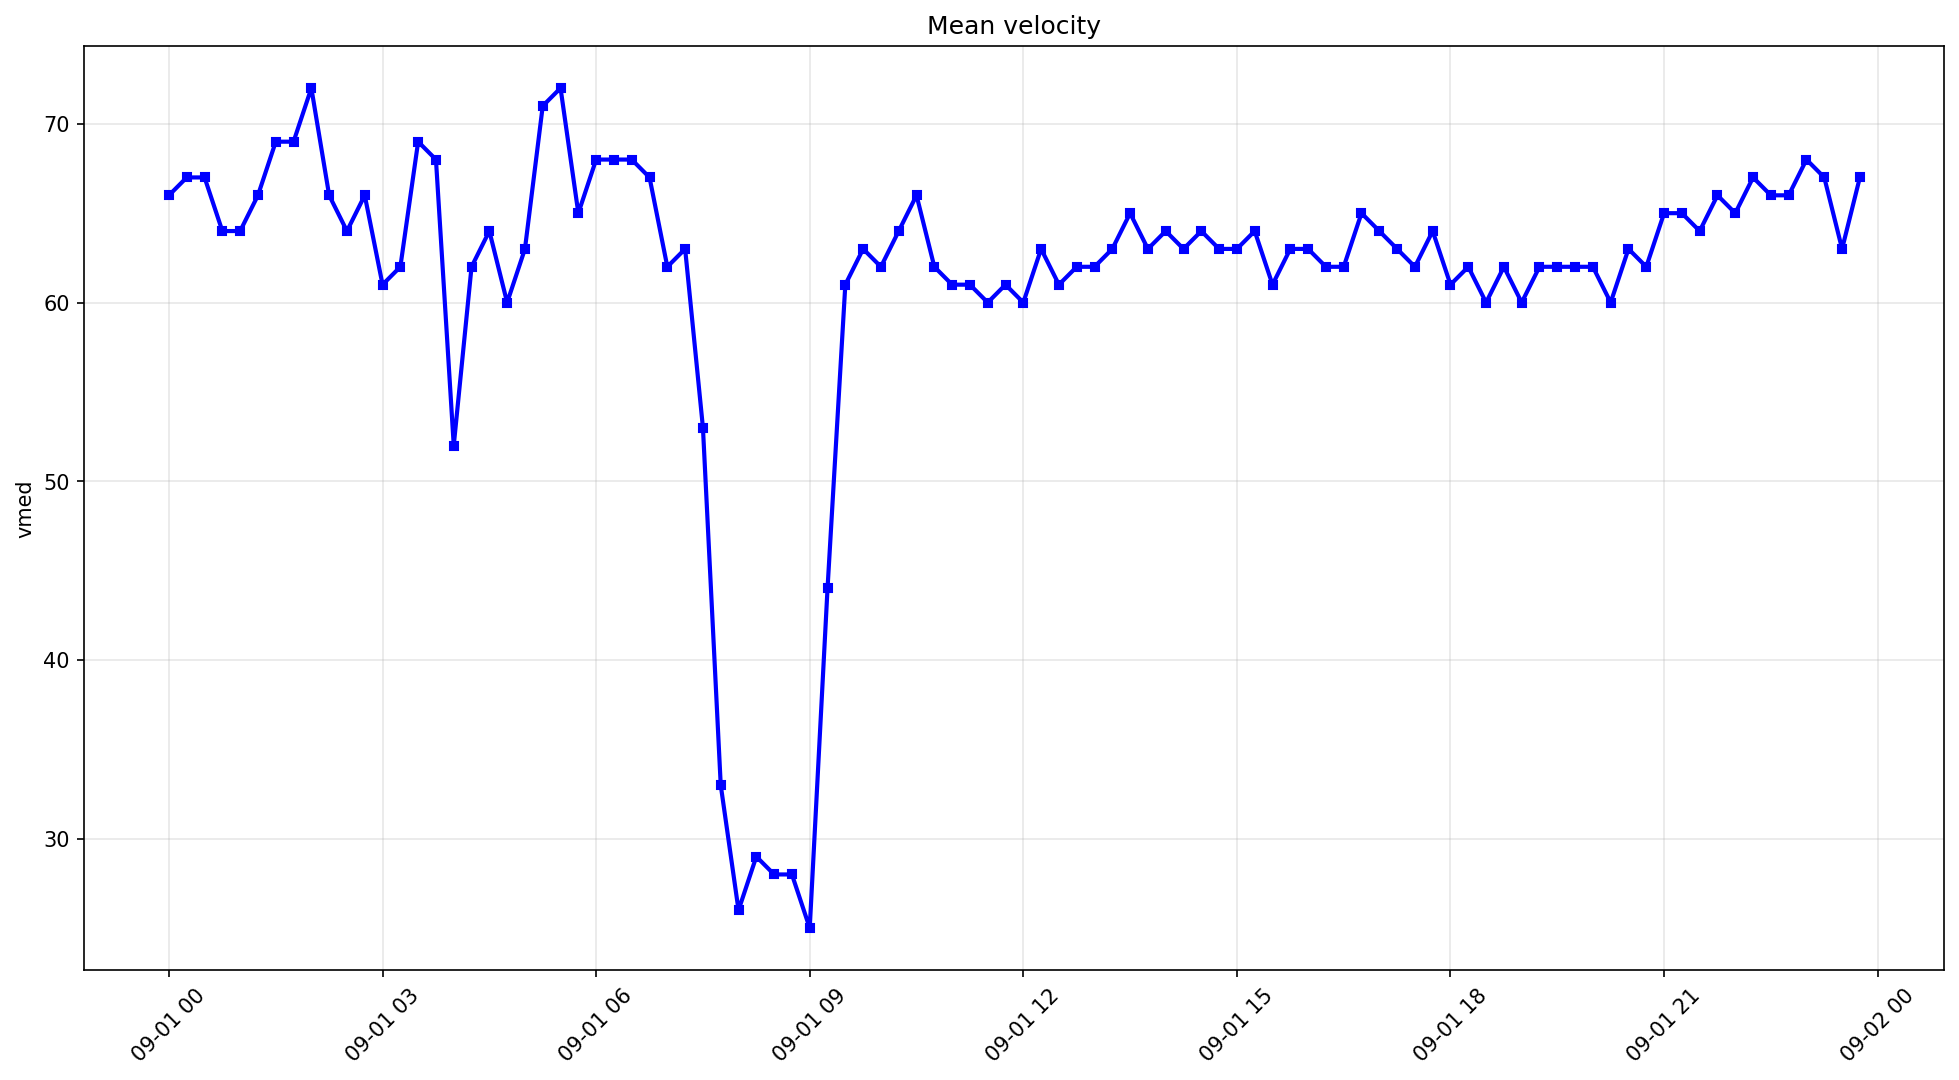

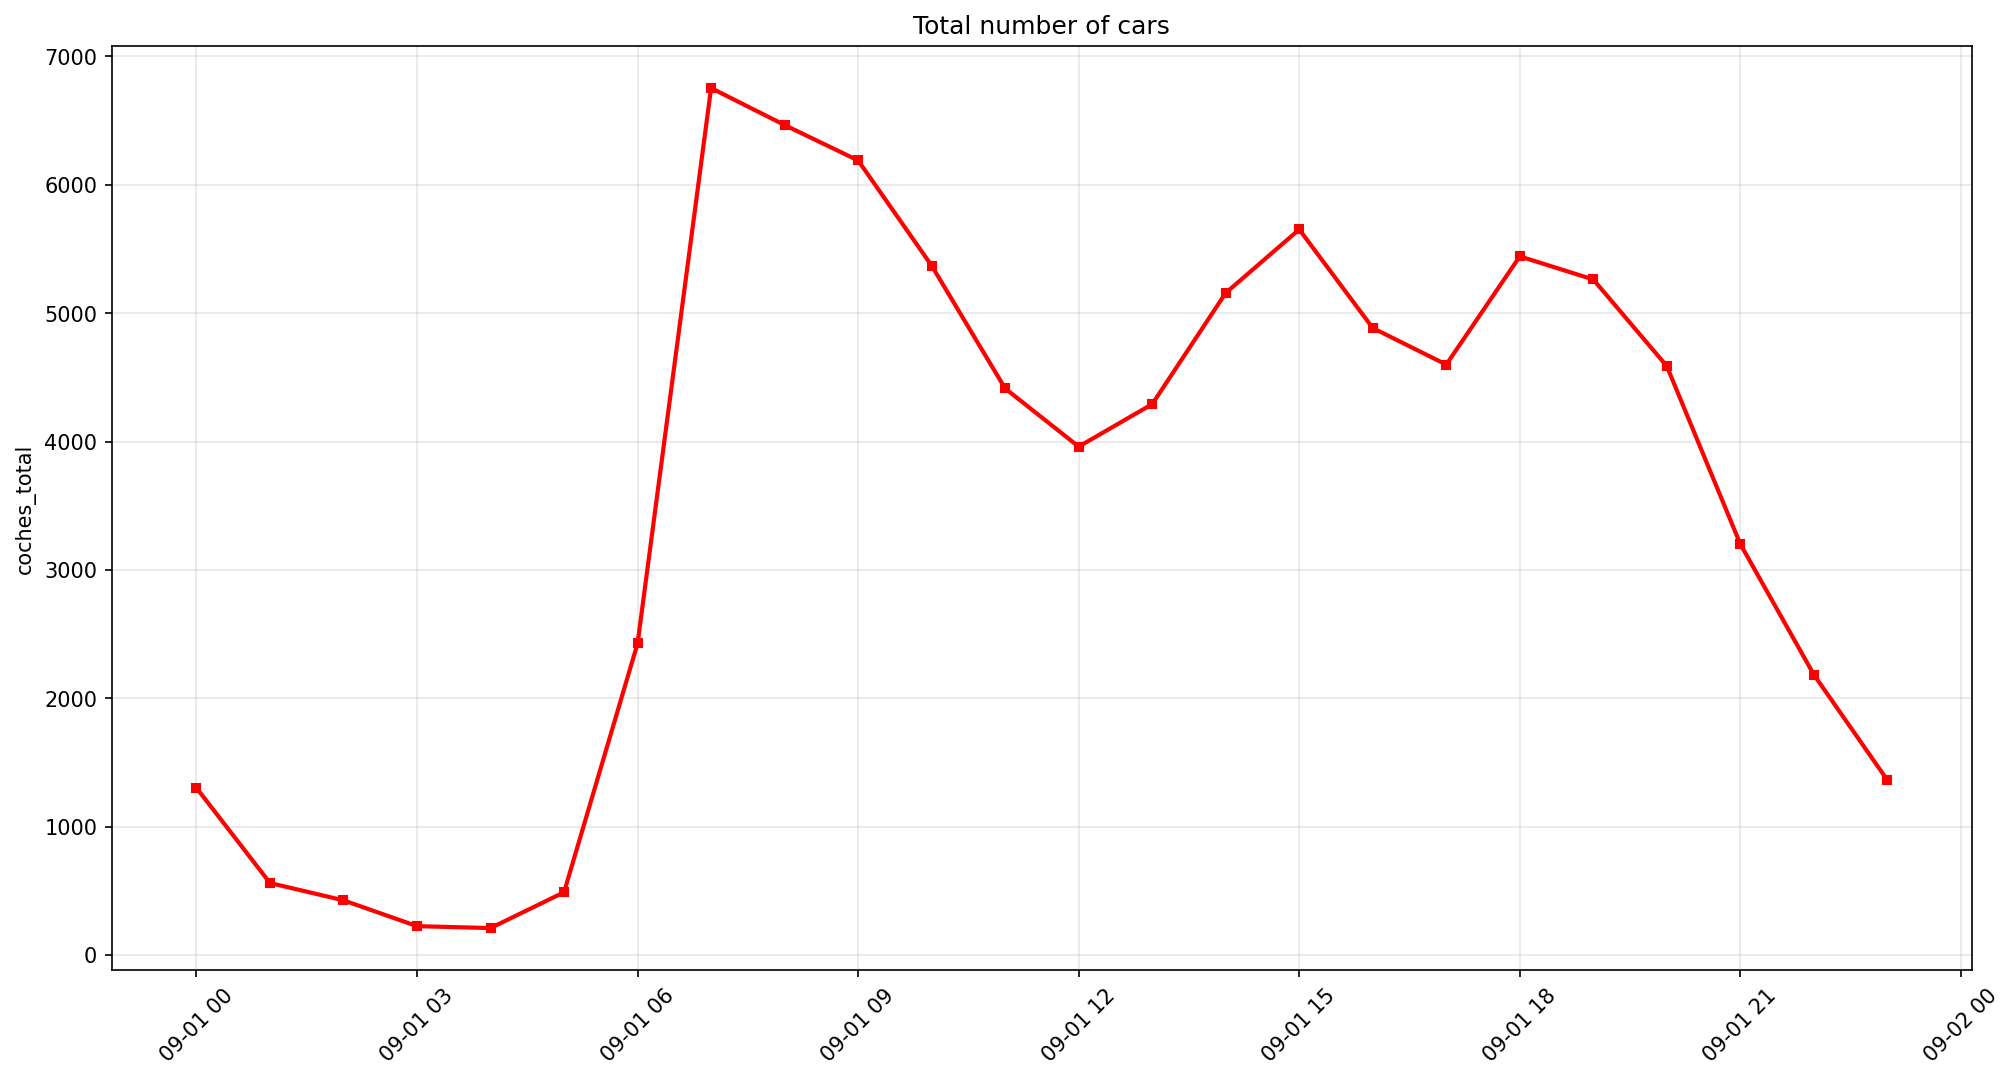

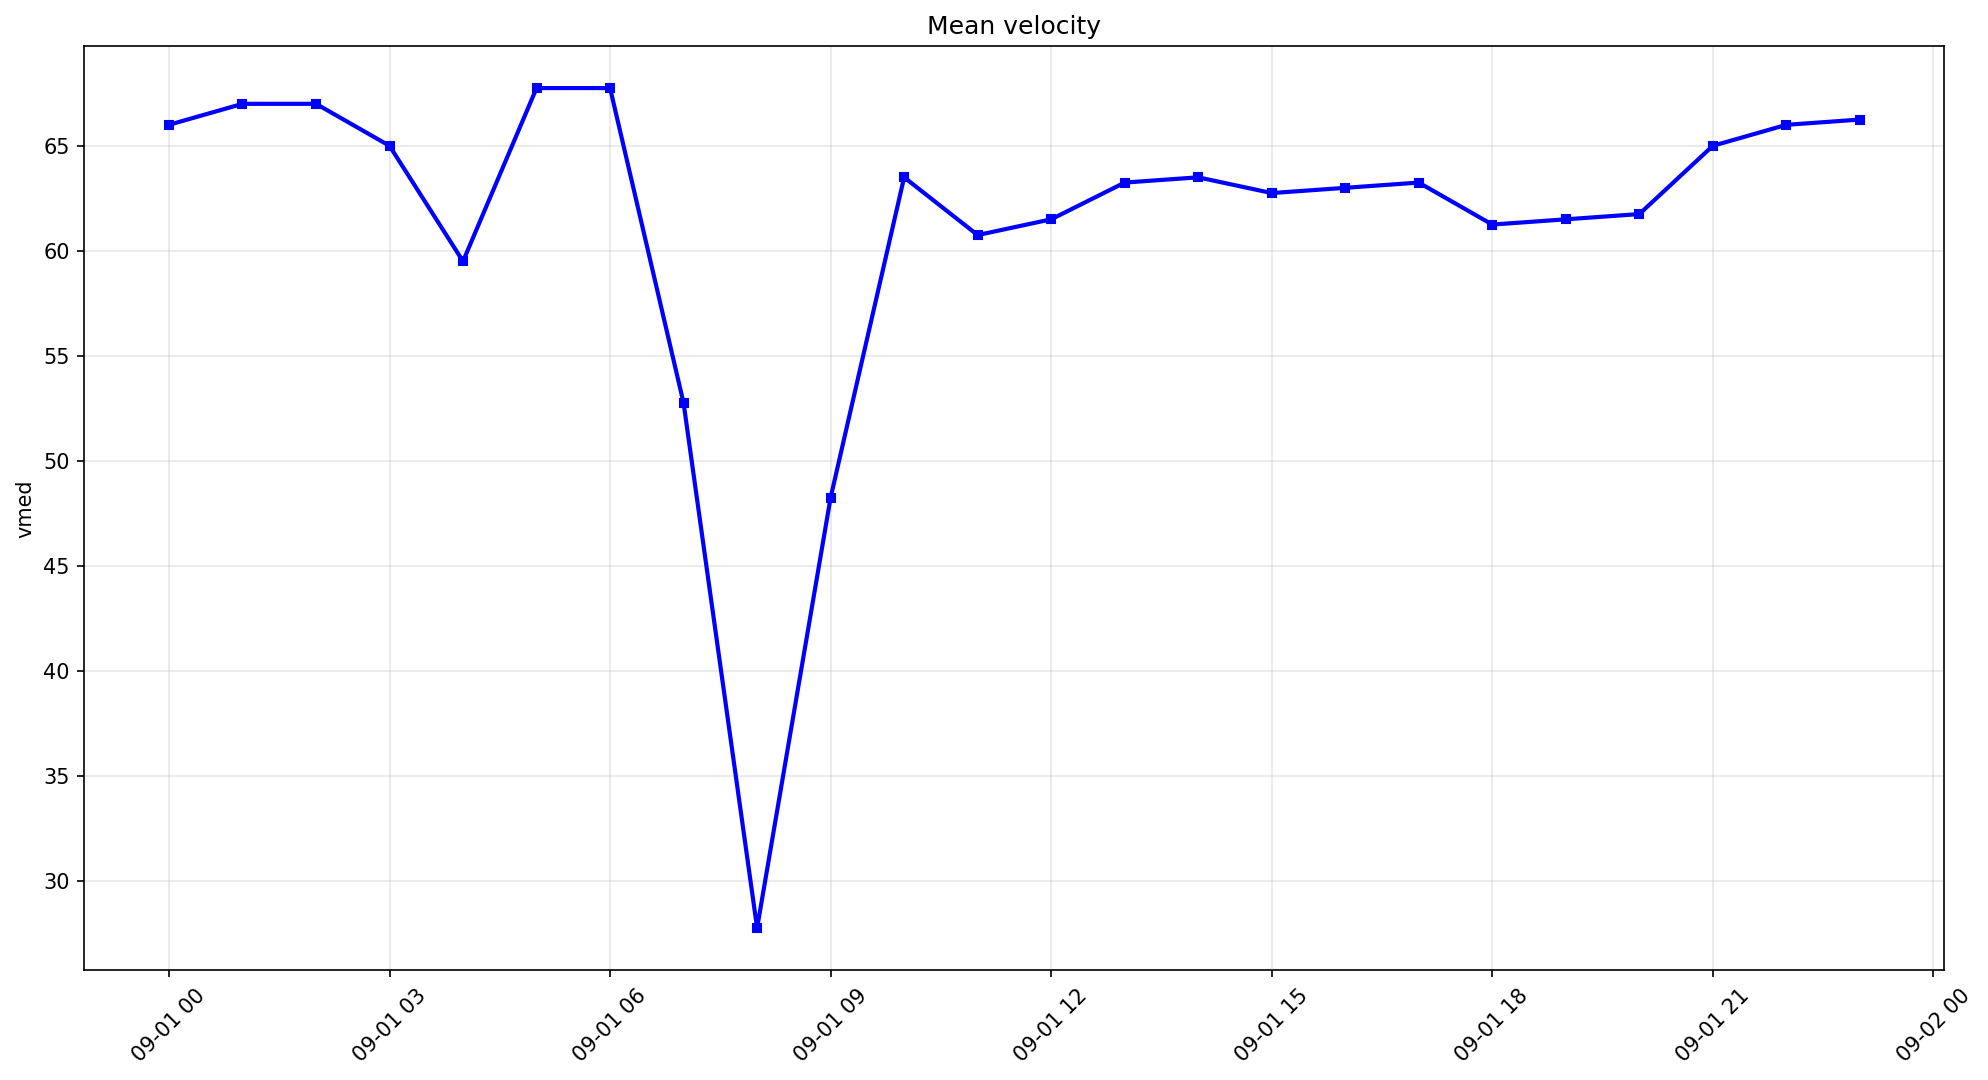

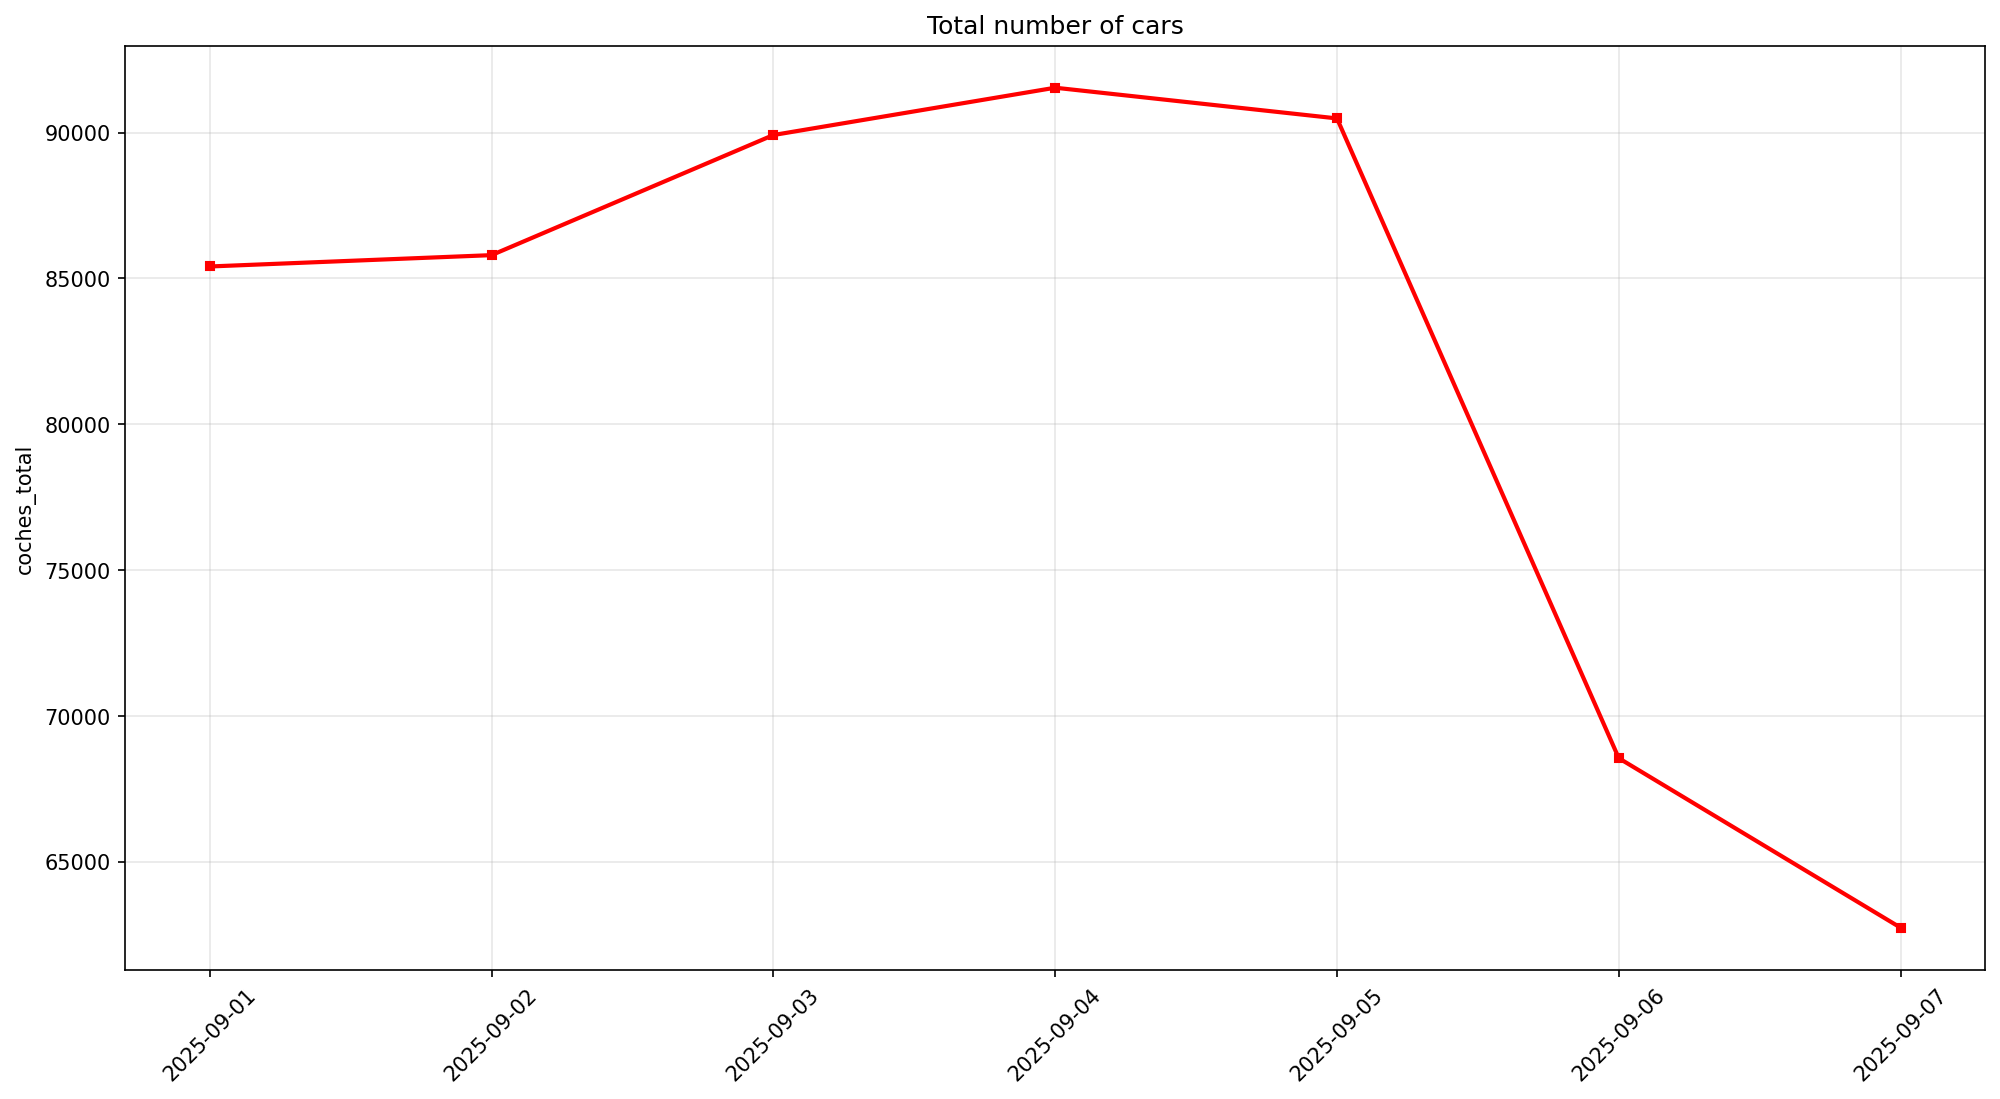

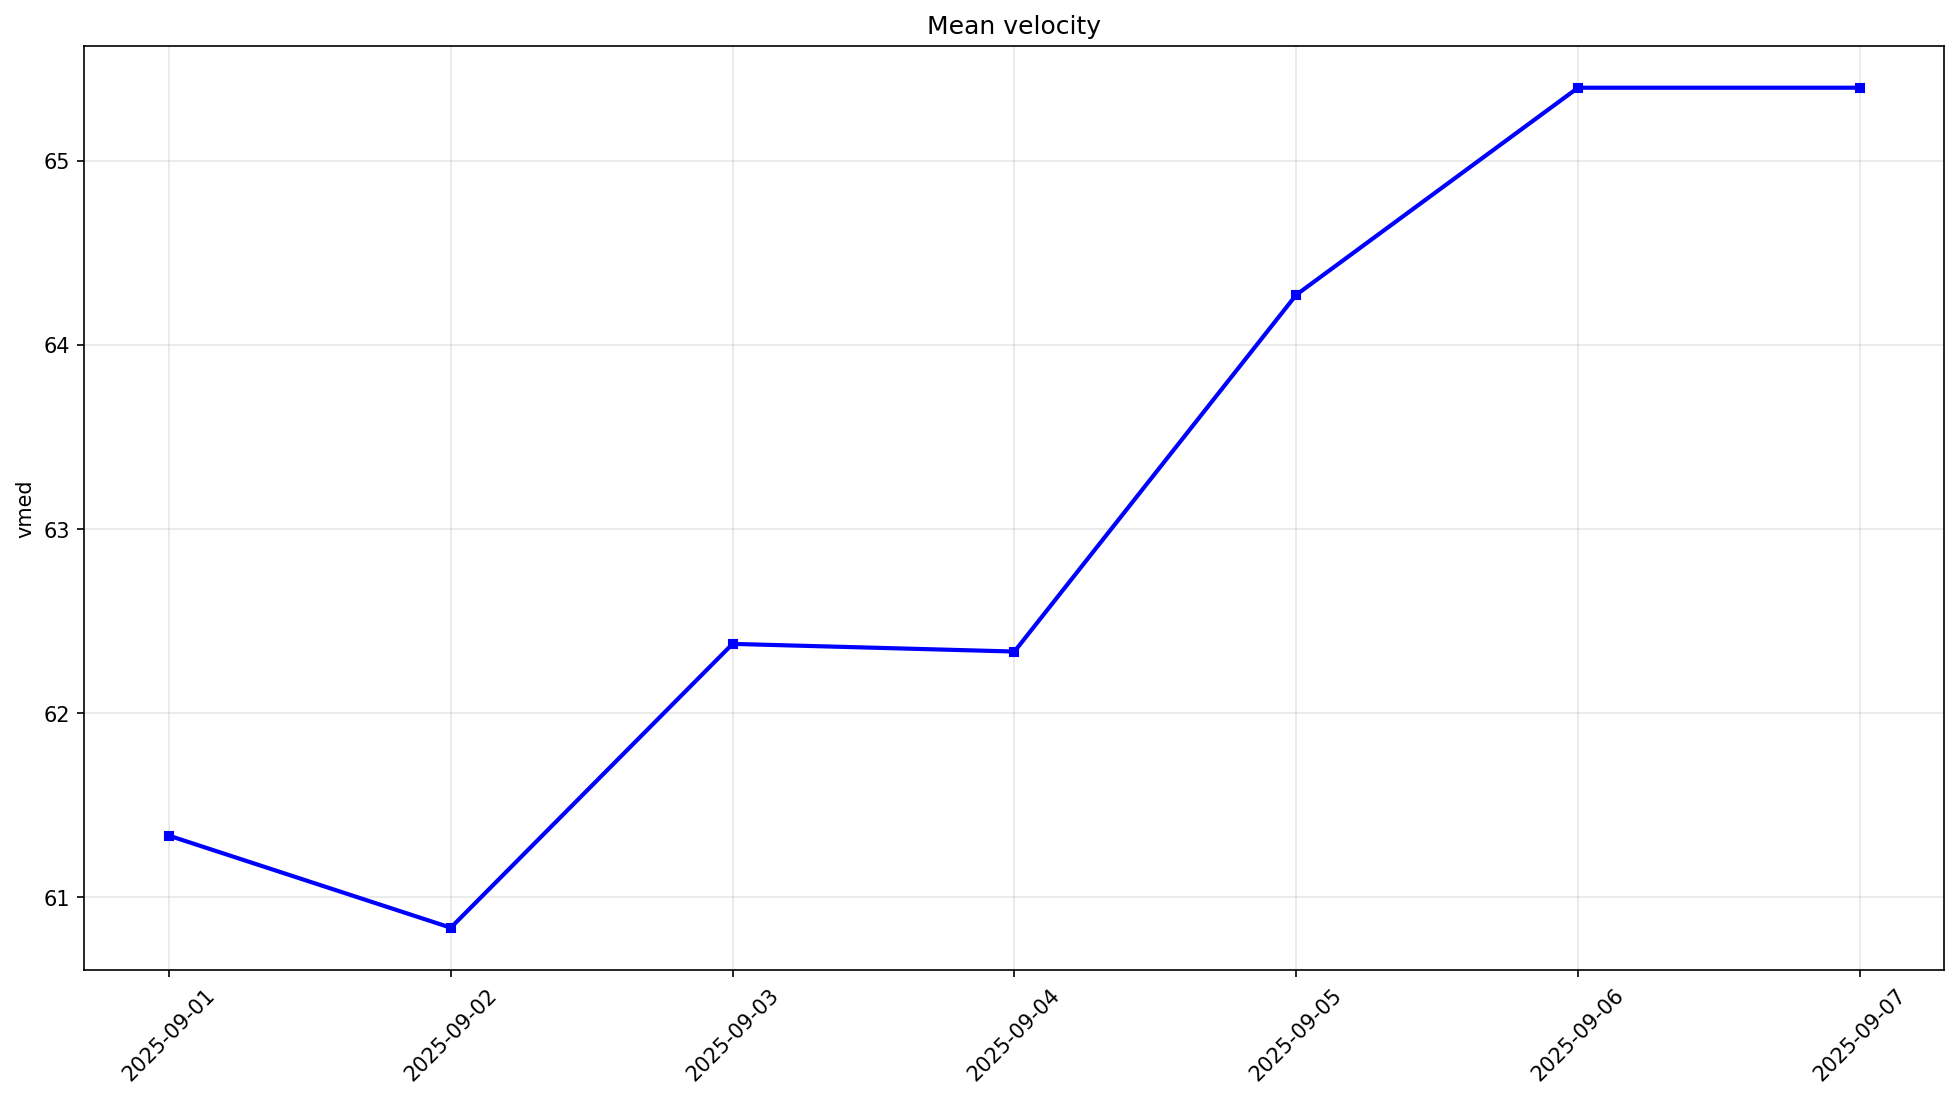

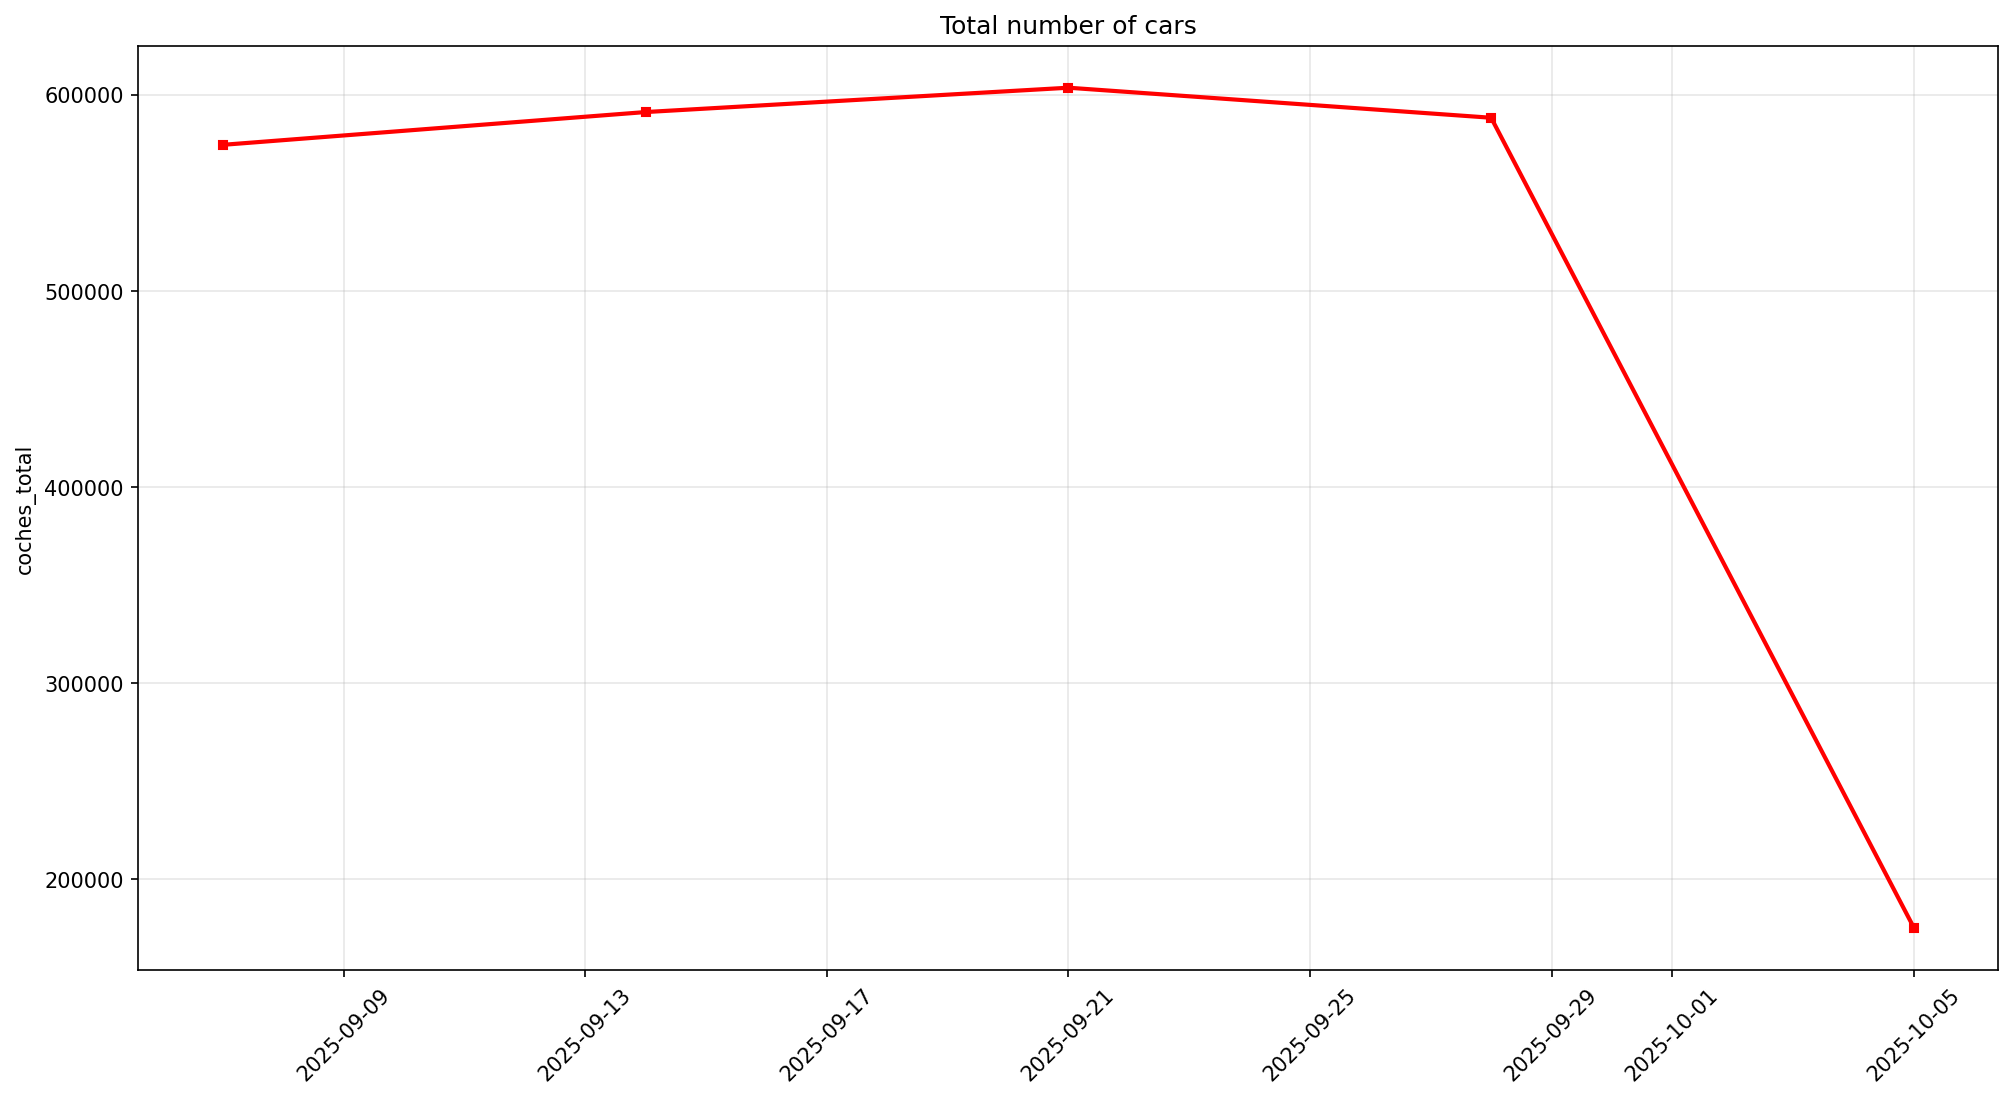

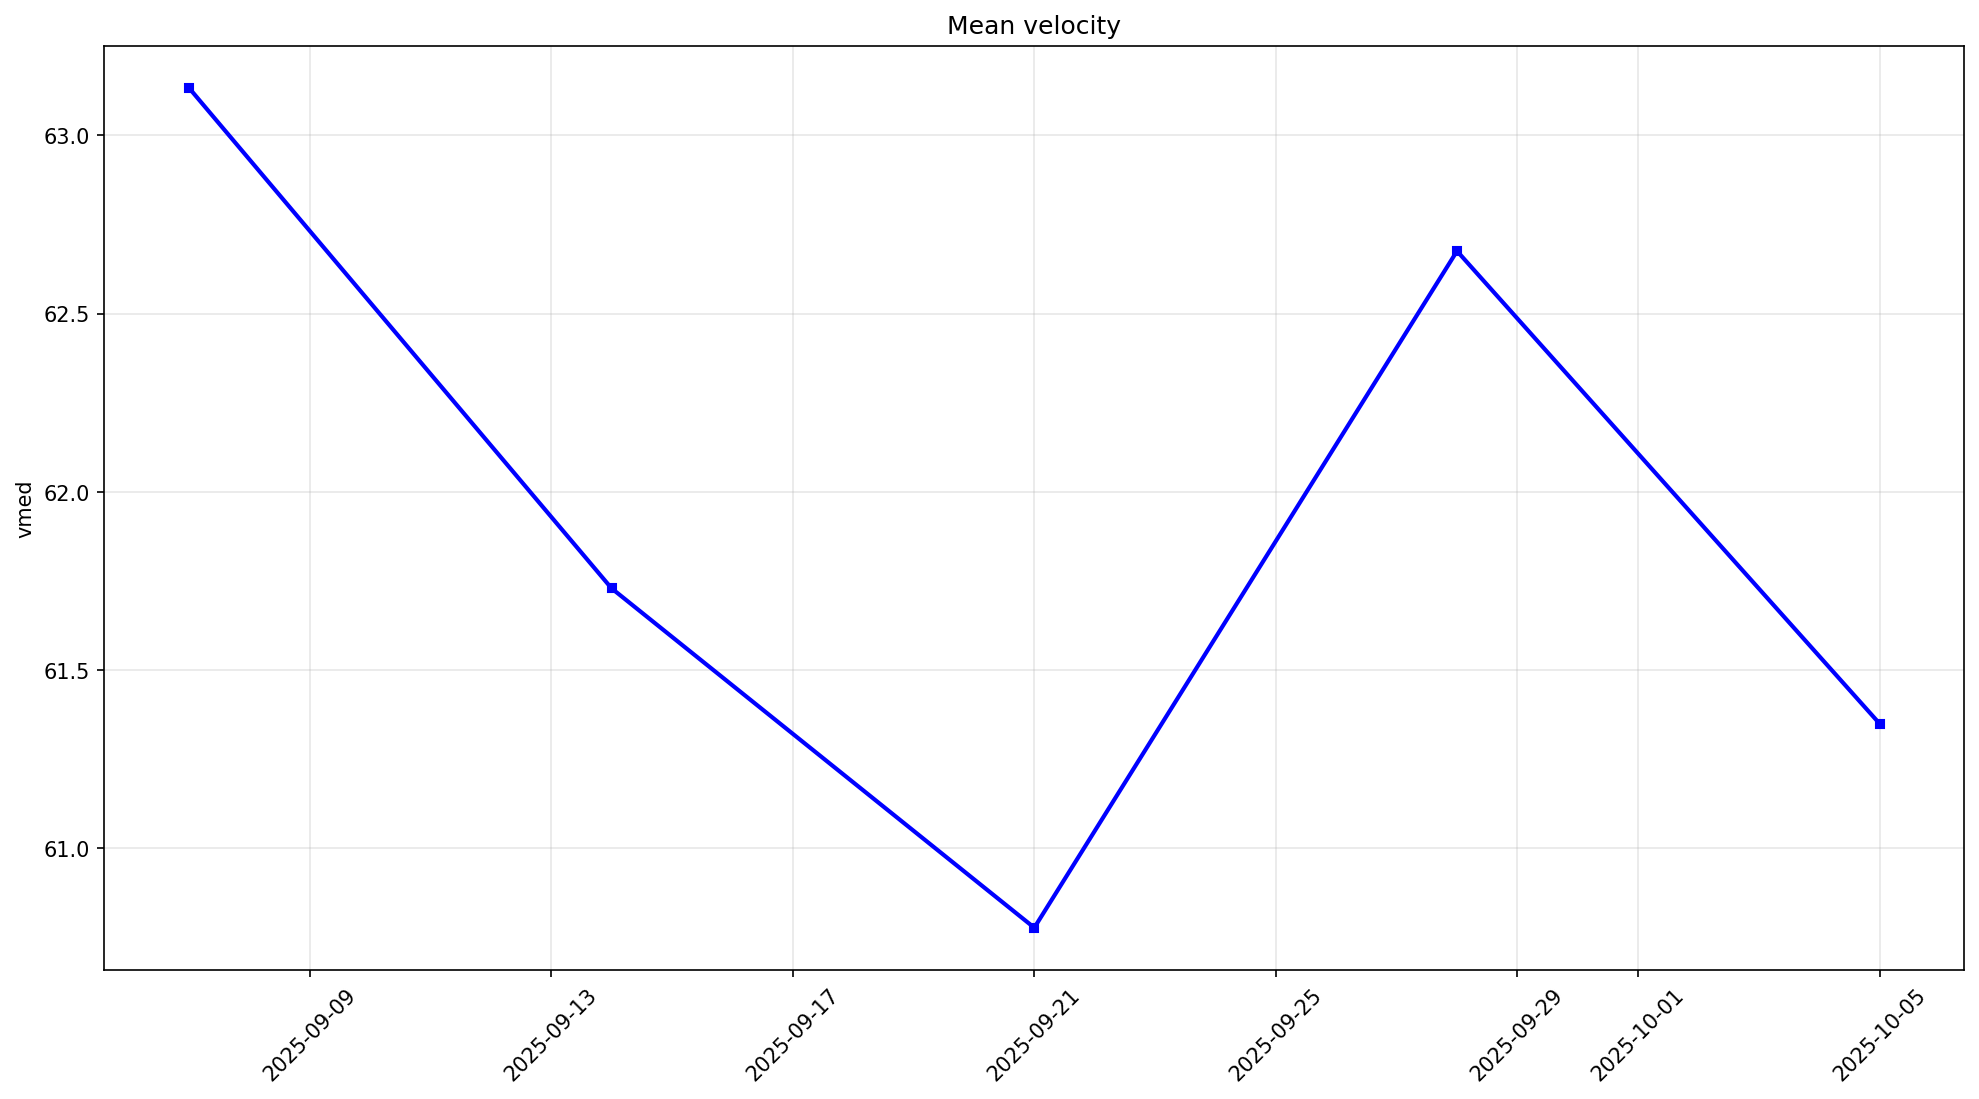

In [124]:
# Example plot
if m30_sensors:
    sensor_id = m30_sensors['max_intensity']
    print(f"Analyzing sensor id: {sensor_id}")
    plot_sensor_traffic(m30_data, sensor_id, "M30")

## Plot monthly patterns

In [ ]:
def plot_sensor_traffic(data, sensor_id, sensor_type, date=None, analysis_type="basic"):
    """
    visualize data for specific sensor
    analysis_type: "basic", "monthly_patterns", "comparative"
    """
    
    # filter sensor data
    sensor_data = data[data['id'] == sensor_id].copy()
    
    # Add time columns for easier filtering
    sensor_data["week"] = sensor_data.index.isocalendar().week
    sensor_data["weekday"] = sensor_data.index.dayofweek  # 0=Monday, 6=Sunday
    sensor_data["weekday_name"] = sensor_data.index.day_name()
    sensor_data["day"] = sensor_data.index.day
    sensor_data["month"] = sensor_data.index.month
    
    if sensor_data.empty:
        print(f"No data for {sensor_id}")
        return
    
    # if date is None take first available date with data
    if date is None:
        date = sensor_data.index.date[0]
        
    target_month = pd.to_datetime(date).month
    target_year = pd.to_datetime(date).year
    
    # Filter for the entire month
    monthly_data = sensor_data[
        (sensor_data.index.month == target_month) & 
        (sensor_data.index.year == target_year)
    ]
    
    if analysis_type == "basic":
        # Your existing basic analysis code...
        daily_data = sensor_data[sensor_data.index.date == pd.to_datetime(date).date()]
        # ... rest of existing code
        
    elif analysis_type == "monthly_patterns":
        
        # 1. Analysis by WEEKDAY (all Mondays, all Tuesdays, etc.)
        fig, axes = plt.subplots(2, 2, figsize=(20, 12))
        fig.suptitle(f'Monthly Traffic Patterns - Sensor {sensor_id} - {target_month}/{target_year}', fontsize=16)
        
        # Weekday patterns
        for stat_idx, stat in enumerate(['coches_total', 'vmed']):
            weekday_patterns = []
            weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            
            for weekday in range(7):
                weekday_data = monthly_data[monthly_data['weekday'] == weekday]
                
                # 15min intervals
                daily_avg_15min = weekday_data.groupby(weekday_data.index.time)[stat].mean()
                weekday_patterns.append(daily_avg_15min)
                
                # Plot individual weekday
                axes[stat_idx, 0].plot(range(len(daily_avg_15min)), daily_avg_15min, 
                                     label=weekday_names[weekday], alpha=0.7, linewidth=2)
            
            axes[stat_idx, 0].set_title(f'{stat} - By Weekday (15min intervals)')
            axes[stat_idx, 0].set_xlabel('Time of Day')
            axes[stat_idx, 0].set_ylabel(stat)
            axes[stat_idx, 0].legend()
            axes[stat_idx, 0].grid(True, alpha=0.3)
        
        # 2. Analysis by DAY OF MONTH (overlay all days)
        for stat_idx, stat in enumerate(['coches_total', 'vmed']):
            unique_days = sorted(monthly_data['day'].unique())
            
            for day in unique_days:
                day_data = monthly_data[monthly_data['day'] == day]
                if not day_data.empty:
                    daily_15min = day_data.groupby(day_data.index.time)[stat].mean()
                    axes[stat_idx, 1].plot(range(len(daily_15min)), daily_15min, 
                                         alpha=0.3, linewidth=1)
            
            # Calculate and plot average
            all_day_avg = monthly_data.groupby(monthly_data.index.time)[stat].mean()
            axes[stat_idx, 1].plot(range(len(all_day_avg)), all_day_avg, 
                                 color='red', linewidth=3, label='Monthly Average')
            
            axes[stat_idx, 1].set_title(f'{stat} - All Days Overlaid (15min intervals)')
            axes[stat_idx, 1].set_xlabel('Time of Day')
            axes[stat_idx, 1].set_ylabel(stat)
            axes[stat_idx, 1].legend()
            axes[stat_idx, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 3. Weekly patterns
        fig, axes = plt.subplots(1, 2, figsize=(20, 6))
        fig.suptitle(f'Weekly Patterns - Sensor {sensor_id}', fontsize=16)
        
        unique_weeks = sorted(monthly_data['week'].unique())
        
        for stat_idx, stat in enumerate(['coches_total', 'vmed']):
            for week in unique_weeks:
                week_data = monthly_data[monthly_data['week'] == week]
                if not week_data.empty:
                    # Daily aggregation for each week
                    daily_week = week_data.resample('D')[stat].mean()
                    axes[stat_idx].plot(range(len(daily_week)), daily_week, 
                                      marker='o', label=f'Week {week}', linewidth=2)
            
            axes[stat_idx].set_title(f'{stat} - By Week')
            axes[stat_idx].set_xlabel('Days in Week')
            axes[stat_idx].set_ylabel(stat)
            axes[stat_idx].legend()
            axes[stat_idx].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


def compare_multiple_sensors(data, sensor_dict, sensor_type, date=None):
    """
    5. Comparative analysis of multiple relevant sensors
    """
    target_month = pd.to_datetime(date).month if date else data.index[0].month
    target_year = pd.to_datetime(date).year if date else data.index[0].year
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle(f'Comparative Analysis - {sensor_type} Sensors - {target_month}/{target_year}', fontsize=16)
    
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    
    for idx, (description, sensor_id) in enumerate(sensor_dict.items()):
        if idx >= len(colors):
            break
            
        sensor_data = data[data['id'] == sensor_id]
        monthly_data = sensor_data[
            (sensor_data.index.month == target_month) & 
            (sensor_data.index.year == target_year)
        ]
        
        if monthly_data.empty:
            continue
            
        # Daily averages
        daily_avg = monthly_data.resample('D').agg({
            'coches_total': 'sum',
            'vmed': 'mean'
        })
        
        # Hourly patterns (average day)
        hourly_avg = monthly_data.resample('H').agg({
            'coches_total': 'mean',
            'vmed': 'mean'
        }).groupby(monthly_data.resample('H').agg({'coches_total': 'mean'}).index.hour).mean()
        
        color = colors[idx % len(colors)]
        
        # Plot daily comparison
        axes[0, 0].plot(daily_avg.index, daily_avg['coches_total'], 
                       color=color, marker='o', label=f'{description} (ID: {sensor_id})', linewidth=2)
        axes[0, 1].plot(daily_avg.index, daily_avg['vmed'], 
                       color=color, marker='s', label=f'{description} (ID: {sensor_id})', linewidth=2)
        
        # Plot hourly comparison
        axes[1, 0].plot(hourly_avg.index, hourly_avg['coches_total'], 
                       color=color, marker='o', label=f'{description} (ID: {sensor_id})', linewidth=2)
        axes[1, 1].plot(hourly_avg.index, hourly_avg['vmed'], 
                       color=color, marker='s', label=f'{description} (ID: {sensor_id})', linewidth=2)
    
    # Configure plots
    titles = ['Daily Total Cars', 'Daily Avg Speed', 'Hourly Avg Cars', 'Hourly Avg Speed']
    ylabels = ['Total Cars', 'Speed (km/h)', 'Cars', 'Speed (km/h)']
    
    for i in range(2):
        for j in range(2):
            idx = i * 2 + j
            axes[i, j].set_title(titles[idx])
            axes[i, j].set_ylabel(ylabels[idx])
            axes[i, j].legend()
            axes[i, j].grid(True, alpha=0.3)
            axes[i, j].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


# Usage examples:
# Basic analysis (your existing functionality)
plot_sensor_traffic(m30_data, m30_sensors['max_intensity'], "M30", analysis_type="basic")

# Monthly pattern analysis
plot_sensor_traffic(m30_data, m30_sensors['max_intensity'], "M30", analysis_type="monthly_patterns")

# Comparative analysis
compare_multiple_sensors(m30_data, m30_sensors, "M30")
compare_multiple_sensors(urb_data, urb_sensors, "URB")